# Initial experiments for the flight path optimization

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

In [2]:
tStart_notebook = time.time()

## global user settings

In [3]:
meshDim = 50
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

## model problem

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
fom_transient = FOM_advectiondiffusion(meshDim=meshDim, dt=0.04, final_time=4)

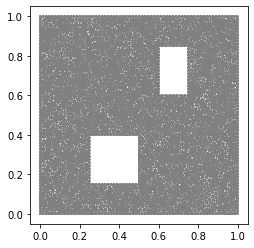

In [5]:
# how the mesh looks like
dl.plot(fom.mesh)

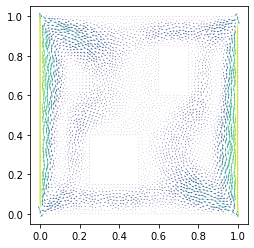

In [6]:
# how the velocity field looks like
dl.plot(fom.velocity)

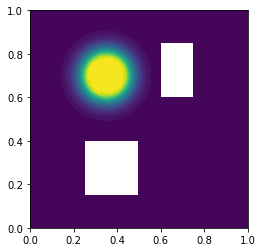

In [7]:
# initial condition
dl.plot(fom.m_true, mesh=fom.mesh)

In [8]:
# model solve
sol_transient, grid_t = fom.implicit_Euler(m_init=fom.m_true, dt=0.04, final_time=4)

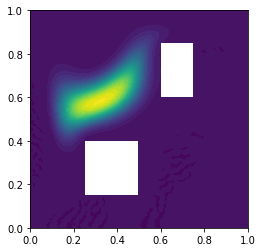

In [9]:
t = 0.8
k = np.argmin(np.abs(grid_t - t))
dl.plot(sol_transient[k], mesh=fom.mesh)

## Steady state

In [10]:
sol_steadystate = fom.solve_steady()

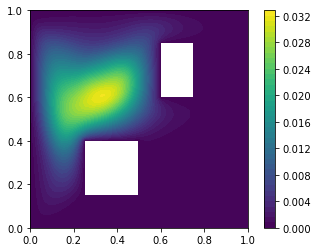

In [11]:
fom.plot(sol_steadystate)

## drone flies in a circle

In [12]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters, eval_mode="point-eval")

In [13]:
# for playing with different flight path, you can specify them anew when asking for the trajectory
flying_parameters_temp = flying_parameters

pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters_temp)

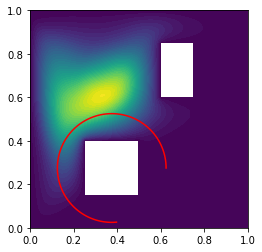

In [14]:
dl.plot(sol_steadystate, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

## Taking measurements

### "convolution" measurements: truncated Gaussians

The drone flies over the point $y$ but then takes a measurement at a random location $x$ with $\|x-y\| \le \sigma$, i.e. a close point but not exactly $y$. The distribution for which $x$ is chosen is described by a truncated Gaussian. We can model this measurement statistically as the expectation of the state under this distribution.

\begin{align}
\Phi(x, y) = \left\{
\begin{array}{ll}
0 & \text{if } \|x-y\| \le 2\sigma \\
C\exp(-\frac{1}{2\sigma^2} \|x-y\|^2) & \text{otherwise}
\end{array}
\right.
\end{align}
where $C$ is chosen such that $\int_{\Omega} Phi(x, y) dx = 1$ for all $y$. We need the re-scaling such that $\Phi(\cdot, y)$ is indeed a probability densition function.

We define the measurement centered around a point $y \in \Omega$ of a state $u \in H^1(\Omega)$ as 
$$\ell_y(u) := \int_{\Omega} u(x) \Phi(x, y) dx 
= \int_{\|x-y\| \le 2\sigma} u(x) \Phi(x, y) dx 
= \mathbb{E}_{\pi_y}[u]
\in \mathbb{R}$$ 
where $\pi_y$ is the probability measure for the probability density function $\Phi(\cdot, y)$.



 measurement steadystate:  0.016186672634456053
 point evaluation:         0.01833908663096185
 compute time:             0.0055599212646484375  s 

 measurement transient:    0.13232386266704363
 point evaluation:         0.14389658080934492
 compute time:             0.004024028778076172  s 



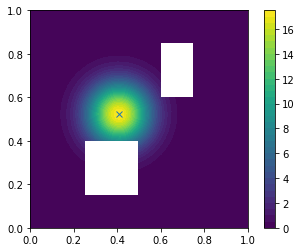

In [15]:
t = 1.2  # at which time should we take the measurement?
k = np.argmin(np.abs(grid_t - t))  # closest time step
pos_x, pos_y = pos[k, :]  # center point around which to take the measurement
sigma_gaussian = 0.1 #0.025  # standard deviation of gaussian functional
# measurement area will be cut off after 2*sigma_weight

# (unscaled) density function for normal distribution
weight = 'exp(-0.5 * ((x[0]-{})*((x[0]-{})) + (x[1]-{})*(x[1]-{})) / {})'.format(pos_x, pos_x, pos_y, pos_y, sigma_gaussian**2)

# cut off after twice the standard deviation (truncated normal)
weight_fct = dl.Expression('max({}, {})'.format(-np.exp(-1), weight), degree=1)  # ideally should use higher degree too

# re-weight such that the integral is = 1
val_integral = dl.assemble(weight_fct*dl.Measure('dx', fom.mesh))
weight_fct = weight_fct/val_integral

fom.plot(weight_fct)
plt.plot([pos_x],[pos_y], marker = 'x') # how the weight function looks like

tStart = time.time()
val_steadystate = dl.assemble(dl.inner(weight_fct, sol_steadystate) * dl.dx)
t_eval_steadystate = time.time()-tStart

tStart = time.time()
val_transient = dl.assemble(dl.inner(weight_fct, sol_transient[k]) * dl.dx)
t_eval_transient = time.time()-tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")

**Note:** Note that we the standard deviation should be smaller here, but at some point the grid size isn't fine enough anymore to accomodate it, so for that reason I'll put `sigma_weight = 0.1` for now such that the measurement area around the drone is a circle with radius 0.2 (twice the standard deviation). The smaller we choose $\sigma$, the closer the measurement should be to the point evaluation.

**Note:** the compute time for the steady-state and the transient case should be comparable here. Sometimes I've seen though that the steady-state case takes a lot longer (almost 1 second), specifically when I change something like the position. So probably there's some caching going here. Unfortunately for the flying drone the measurement position is going to be different every time step, so we'll need to calculate with the worse compute time unfortuantely :(

Hopefully we can speed up some of these computations, I'm just going for the obvious steps right now, I'm not optimizing the code.

**Note:** Thinking back to my conversation with Don Blankenship about how they measure in Antarctica, I think this model makes sense: He mentioned that for any measurement there exists a point on the ground where this measurement is correct (modulo noise) but that the position of this point is only known within an interval of 8m on the right-left axis of the plane. He also said something about how far the divice measures towards forwards and backwards, but I don't have that information at hand. In any case, using an iid Gaussian is probably not ideal, but a truncated Gaussian makes sense I think.

### "convolution" measurements: uniform

Another possibility for modelling the measurements is to choose a weighted characteristic function $\Phi(x,y) = \|\Omega_y\|^{-1} \mathbb{1}_{\Omega_y}(x)$ for a measureable domain $\Omega_y \subset \Omega$, $y \in \Omega_y$. In this case a measurement 
$$\ell_y(u) := \int_{\Omega} u(x) \Phi(x,y) dx = \frac{1}{\|\Omega_y\|} \int_{\Omega_y} u(x) dx$$ 
is the mean value of a state $u$ over the subdomain $\Omega$. In the code below I've chosen $\Omega_y$ as a circle around the point $y$. Well, at least it's a circle when it completely fits into the doamin.


 measurement steadystate:  0.01759122381709457
 point evaluation:         0.01833908663096185
 compute time:             0.04966402053833008  s 

 measurement transient:    0.15547428656581705
 point evaluation:         0.14389658080934492
 compute time:             0.047418832778930664  s 



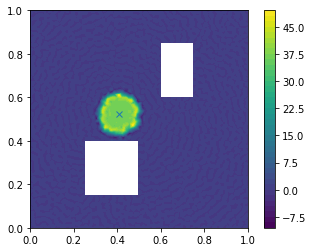

In [16]:
# for comparison, let's use the same setting as before. 
# the cutoff radius before was 2*sigma_weight, so we could keep the reach of the measurement the same with
# radius_uniform = 2 * sigma_gaussian
# but for sigma_gaussian = 0.1 that seems ridiculously large
radius_uniform = sigma_gaussian

## If you want to try out changes faster, comment this code in:
# t = 1.2  # at which time should we take the measurement?
# k = np.argmin(np.abs(grid_t - t))  # closest time step
# pos_x, pos_y = pos[k, :]  # center point around which to take the measurement
# radius_uniform = 0.05 # radius around the center


class Omega_circle(dl.SubDomain):
    
    def __init__(self, pos, radius):
        super().__init__()
        self.center = pos
        self.radius = radius
    
    def inside(self, x, on_boundary):
        if la.norm(x - self.center) <= self.radius:
            return True
        return False
        
subdomain = Omega_circle(pos = np.array([pos_x, pos_y]), radius = radius_uniform)
material = dl.MeshFunction("size_t", fom.mesh, fom.mesh.topology().dim(), 0)
subdomain.mark(material, 1)

weight_fct = Parameter(material, np.array([0, 1]), degree = 0)

# re-weight such that the integral is = 1
val_integral = dl.assemble(weight_fct*dl.Measure('dx', fom.mesh))
weight_fct = weight_fct/val_integral
# we would just divide by (np.pi*radius_uniform**2) here, but if the mesh is not fine enough this will cause issues
# (we won't converge towards point evaluation even though that's our theoretical limit since our FE solution is continuous)

# how the weight function looks like
fom.plot(weight_fct)
plt.plot([pos_x],[pos_y], marker = 'x') 

tStart = time.time()
val_steadystate = dl.assemble(dl.inner(weight_fct, sol_steadystate) * dl.dx)
t_eval_steadystate = time.time()-tStart

tStart = time.time()
val_transient = dl.assemble(dl.inner(weight_fct, sol_transient[k]) * dl.dx)
t_eval_transient = time.time()-tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")


### comparison

Computing the integrals can sometimes take a bit, so I'm introducing the slicer variable to only measure every so often, i.e. every `slicer`-th time step. This is only because I'm impatient when I run the notebook from the start, outside code development we will measure at every time step.

In [17]:
slicer = 1

tStart = time.time()

d_steadystate_gaussian = drone.measure(pos[::slicer, :], sol_steadystate, mode="gaussian")
d_steadystate_pointwise = drone.measure(pos, sol_steadystate, mode="point-eval")
d_steadystate_uniform = drone.measure(pos[::slicer, :], sol_steadystate, mode="uniform")

print("Runtime for half this block: {} min".format((time.time()-tStart)/60))

d_transient_gaussian = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="gaussian")
d_transient_pointwise = drone.measure(pos, sol_transient, mode="point-eval")
d_transient_uniform = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="uniform")

print("Runtime for this block: {} min".format((time.time()-tStart)/60))

Runtime for half this block: 0.16689889828364055 min
Runtime for this block: 0.3191342830657959 min


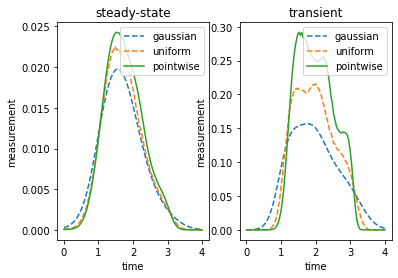

In [18]:
fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t[::slicer], d_steadystate_gaussian, label="gaussian", linestyle = "--")
axs[0].plot(grid_t[::slicer], d_steadystate_uniform, label="uniform", linestyle = "--")
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t[::slicer], d_transient_gaussian, label="gaussian", linestyle = "--")
axs[1].plot(grid_t[::slicer], d_transient_uniform, label="uniform", linestyle = "--")
axs[1].plot(grid_t, d_transient_pointwise, label="pointwise")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

**note:** The gaussian measurements are further away from the pointwise measurements here because the measurement radius `2*drone.sigma_gaussian` is larger than `drone.radius_uniform`.

## Parameter-to-observable map

For the drone class I think it should mimick what the drone does in practice: flying and measureing. It doesn't necessarily evaluate probabilities itself or choose the parameters of its flight path. For these tasks I'm introducing a separate class `Brain`. If the drone eventually flies and measures autonomously think of `Brain` as the brain of the drone, if not, then it's the brain of the decisionmaker. 

In [19]:
brain = Brain(fom=fom, drone=drone)

In [20]:
d_test = brain.apply_para2obs(para=np.array([1]), mode="point-eval")
print("Sanity check: ", np.isclose(d_test,  d_steadystate_pointwise).all())

Sanity check:  True


**Note:** One reason for why the sanity check might fail is that the drone flight parameters, e.g., speed, might have changed from the defaults in the code above.

In [21]:
brain_transient = Brain(fom=fom_transient, drone=drone)
d_test = brain_transient.apply_para2obs(para=np.array([1]), mode="point-eval")
print("Sanity check: ", np.isclose(d_test, d_transient_pointwise).all())

Sanity check:  True


## Noise model

The correct modelling of the noise distribution turned out somewhat mind-woggling. I've returned to a deterministic-looking kind approach where I just choose the weight functin for the measurements. At the moment I'm using:

$$
\|d-d_{obs}\|^2_{\Gamma_{noise}^{-1}} \stackrel{dt \rightarrow 0}{\rightarrow} c_{scale}\int_0^T c_{diff} (\frac{d}{dt}d(s)-\frac{d}{dt}d_{obs}(s))^2 + (d(s)-d_{obs}(s))^2 ds
$$

<!-- Let's assume an additive Gaussian noise model, $d_{obs} = G(m) + \eta$ where $d_{obs}$ is the noisy observational data, $G : "parameter-space" \rightarrow H^{1}(0, T)$ the parameter to observable map going from the parameter space into $H^1(0, T)$ to denote scalar, time-depend measurements. I think $H^1(0,T)$ makes sense here, rather than $L^2(0,T)$, because under enough regularity on the PDE solution and the flight path the observed data should be continuous and differentiable. That's something to prove though. For now I'm assuming it's ok to use $H^1(\Omega)$ because it makes sense from a physical perspective and the proof should be quite simple for elliptic and parabolic problems. It might get more complicated with shocks, but that's a problem for another day.

**TODO:** Prove measurements are continuous and differentiable (to some degree) so that we know in which space we model the noise.

Under the assumptions above, we model the noise $\eta \in H^1(0,T)$, $\eta \sim \mathcal{N}(0, C)$. Following https://epubs.siam.org/doi/pdf/10.1137/12089586X for discretizations that respect the functin-space setting, we choose $C = A^{-2}$ where $A$ is an elliptic operator. Specifically, the solution $m=A^{-1}q$ satisfies:

$$
c_{scaling} \int_0^T c_{diffusion} \nabla p \cdot \nabla m + pm ds = \int_0^T p q ds \quad \forall~p \in H^1(0,T)
$$

We can then measure the data misfit $d - d_{obs}$ as: $\|A(d-d_{obs})\|_{L^2(0,T)}$.

Assume $H^1(0,T)$ has been discretized such that the we obtain an approximation $\mathbf{m}$ to $m=A^{-1}q$ by solving a linear system $\mathbf{K}\mathbf{m} = \mathbf{M} \mathbf{q}$. In the code below I'm computing the matrices $\mathbf{K}$, $\mathbf{M}$ for linear finite elements. Note that $\mathbf{M}$ is the $L^2(0,T)$ mass matrix for the discretization. Then we measure the (discrete) data $\mathbf{d} - \mathbf{d}_{obs}$ as: $\|\mathbf{M}^{-1}\mathbf{K}(\mathbf{d} - \mathbf{d}_{obs})\|_{\mathbf{M}}$. For our noise covariance matrix we have:

$$
\Gamma_{noise} = \mathbf{K}^{-1} \mathbf{M} \mathbf{K}^{-T}
\qquad \qquad
\Gamma_{noise}^{-1} = \mathbf{K}^T \mathbf{M}^{-1} \mathbf{K}
$$

**Warning:** At least that's what I think right now, but the paper says "$\Gamma_{pr} = \mathbf{A}^{-2}$" which would with their definitions imply $\Gamma_{pr} = \mathbf{K}^{-1}\mathbf{M}\mathbf{K}^{-1}\mathbf{M}$. They also use this identity further during their paper, so I'm somewhat confused righ tnow where they get this from.

**TODO:** It should absolutely be possible to use FEniCS for the discretization. However, when I tried to transform `grid_t` to a FEniCS mesh I ran into errors. I decided it was faster to implement it by hand for now. -->





<!-- Mass matrix entries:
$$\int_0^{dt} \frac{s^2}{dt^2} ds = \frac13 dt$$

$$\int_0^{dt} \frac{s(dt-s)}{dt^2} ds =\frac{1}{dt^2}\int_0^{dt} dt*s - s^2 ds = \frac12 dt - \frac13 dt = \frac16 dt$$ -->

In [22]:
noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)

Text(0.5, 0, 'time')

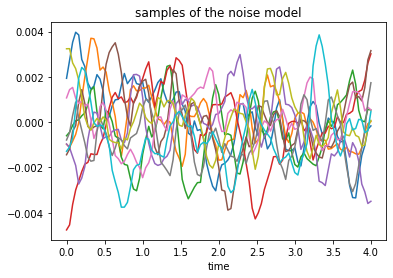

In [23]:
test = noise_model.sample(n_samples = 10)

fig, ax = plt.subplots(1,1)
for i in range(10):
    ax.plot(grid_t, test[:, i])
    
ax.set_title("samples of the noise model")
ax.set_xlabel("time")

**WARNING:** I'm not entirely sure if the way we are drawing the noise with the changed interpretaiton of the noise model is entirely correct.

In [24]:
# todo: double-check that this is indeed how samples are drawn

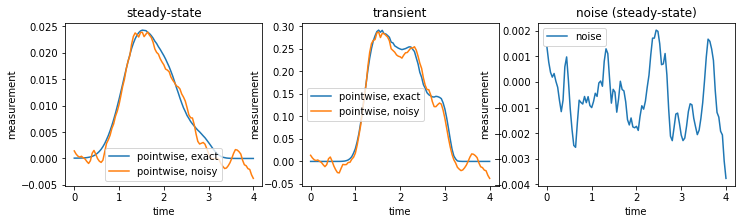

In [25]:
noise = noise_model.sample()

fig, axs = plt.subplots(1,3, figsize=(12, 3))
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise, exact")
axs[0].plot(grid_t, d_steadystate_pointwise + noise, label="pointwise, noisy")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t, d_transient_pointwise, label="pointwise, exact")
axs[1].plot(grid_t, d_transient_pointwise + 10*noise, label="pointwise, noisy")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

axs[2].plot(grid_t, noise, label="noise")

axs[2].set_xlabel("time")
axs[2].set_ylabel("measurement")
axs[2].set_title("noise (steady-state)")
axs[2].legend()

**Note:** the measurements for the transient case are much larger, so we'll need a different noise model for that case (probably). Here, for better visibility of the noise, I've multiplied it with 10.

### noise covariance matrix
The noise covariance matrix requires sparse matrix solves, so we shouldn't explicitely compute it. However, its enduced norm is in `noise_model.compute_noisenorm2(d)`:

In [26]:
noise = noise_model.sample()

print("noise:       ", np.sqrt(noise_model.compute_noisenorm2(noise)))
print("measurement: ", np.sqrt(noise_model.compute_noisenorm2(d_steadystate_pointwise + noise)))

noise:        0.12692669822672484
measurement:  0.8173155769451268


In [27]:
noise = noise_model.sample(n_samples = 3)
noise_model.compute_noisenorm2(noise)

array([[ 0.01514446,  0.00126502,  0.00365121],
       [ 0.00126502,  0.01485753, -0.00489639],
       [ 0.00365121, -0.00489639,  0.01927725]])

**Question:** Does it make sense to model the noise this way? Thinking about it, the paper https://epubs.siam.org/doi/pdf/10.1137/12089586X introduces everything so we can model noise in $L^2$, but for us it might make more sense to work in $H^1$. If we modelled the data misfit deterministically, we would probably just use the $H^1$-inner product matrix to weigh everything. 

## Posterior

### 1-dimensional
as a first test, we consider the inference of a single scaling parameter only.

In [28]:
prior = Prior(covar = np.eye(1), mean = np.zeros((1,)))
brain.set_prior(prior)
brain.set_noise_model(noise_model)

In [29]:
post_steadystate = brain.compute_posterior(data = d_steadystate_pointwise)

In [30]:
noise_model_transient = NoiseModel(grid_t=grid_t, c_scaling=1e+1, c_diffusion = 0.01)
brain_transient = Brain(fom=fom_transient, drone=drone, prior=prior, noise_model=noise_model_transient)

In [31]:
post_transient = brain_transient.compute_posterior(data = d_transient_pointwise)

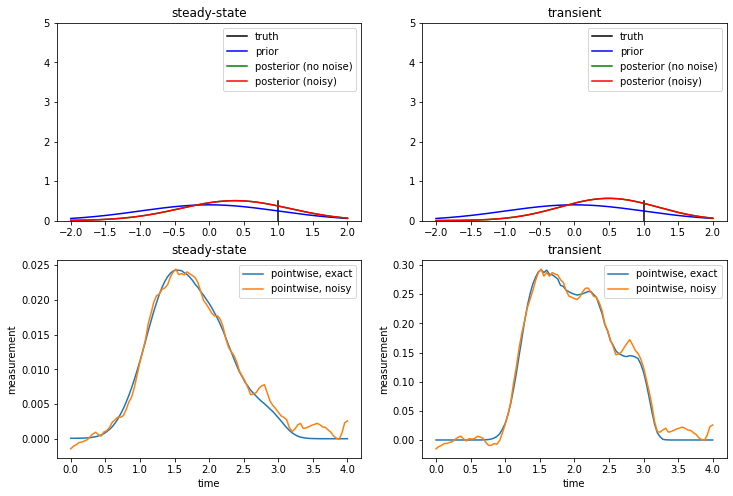

In [32]:
noise = noise_model.sample()

fig, axs = plt.subplots(2,2, figsize=(12, 8))

# true
axs[0,0].plot([1, 1], [0, 0.5], color="black", label="truth")
axs[0,1].plot([1, 1], [0, 0.5], color="black", label="truth")

# prior
variance = prior.covar[0,0]
sigma = math.sqrt(variance)
x = np.linspace(prior.mean[0] - 2*sigma, prior.mean[0] + 2*sigma, 200)
vals = stats.norm.pdf(x, prior.mean[0], sigma)
axs[0,0].plot(x, vals, label = "prior", color = "b")
axs[0,1].plot(x, vals, label = "prior", color = "b")

# posterior, steadystate
variance = post_steadystate.covar[0,0]
sigma = math.sqrt(variance)
vals = stats.norm.pdf(x, post_steadystate.compute_mean(data = d_steadystate_pointwise), sigma)
axs[0,0].plot(x, vals, label = "posterior (no noise)", color = "g")

vals = stats.norm.pdf(x, post_steadystate.compute_mean(data = d_steadystate_pointwise + noise), sigma)
axs[0,0].plot(x, vals, label = "posterior (noisy)", color = "r")

# posterior, transient
variance = post_transient.covar[0,0]
sigma = math.sqrt(variance)
vals = stats.norm.pdf(x, post_transient.compute_mean(data = d_transient_pointwise), sigma)
axs[0,1].plot(x, vals, label = "posterior (no noise)", color = "g")

vals = stats.norm.pdf(x, post_transient.compute_mean(data = d_transient_pointwise + noise), sigma)
axs[0,1].plot(x, vals, label = "posterior (noisy)", color = "r")


axs[1,0].plot(grid_t, d_steadystate_pointwise, label="pointwise, exact")
axs[1,0].plot(grid_t, d_steadystate_pointwise + noise, label="pointwise, noisy")

axs[1,0].set_xlabel("time")
axs[1,0].set_ylabel("measurement")
axs[1,0].set_title("steady-state")
axs[1,0].legend()

axs[1,1].plot(grid_t, d_transient_pointwise, label="pointwise, exact")
axs[1,1].plot(grid_t, d_transient_pointwise + 10*noise, label="pointwise, noisy")

axs[1,1].set_xlabel("time")
axs[1,1].set_ylabel("measurement")
axs[1,1].set_title("transient")
axs[1,1].legend()


axs[0,0].set_ylim(0, 5)
axs[0,1].set_ylim(0, 5)
axs[0,0].set_title("steady-state")
axs[0,1].set_title("transient")

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

#### Utiltiy functions
For the 1-parameter case, all utility functions return the same value because the posterior covariance matrix is just a $1 \times 1$ matrix.

In [33]:
print("steady-state:")
print("A-OED:", brain.eval_utility(post_steadystate, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_steadystate, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_steadystate, oed_mode="E"), "\n")

print("transient:")
print("A-OED:", brain.eval_utility(post_transient, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_transient, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_transient, oed_mode="E"), "\n")

steady-state:
A-OED: 0.6264553770644539
D-OED: 0.6264553770644539
E-OED: 0.6264553770644539 

transient:
A-OED: 0.503323382718925
D-OED: 0.503323382718925
E-OED: 0.503323382718925 



### multiple parameters
Next notebook

## The End.

In [34]:
t_notebook = time.time() - tStart_notebook
print("Runtime of this notebook: {} min".format(t_notebook / 60))

Runtime of this notebook: 0.6346586465835571 min
